In [5]:
pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.3 MB 143.4 kB/s eta 0:28:00
   ---------------------------------------- 0.5/241.3 MB 143.4 kB/s 

In [33]:
import os
import json
import math
import time
import random
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --------- 0.1 Reproducibility ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --------- 0.2 Config ----------
@dataclass
class CFG:
    # paths
    train_ai_path: str = "train_ai.npy"
    train_human_path: str = "train_human.npy"
    valid_jsonl: str = "validation.jsonl"
    test_jsonl: str = "test_features.jsonl"
    artifacts_dir: str = "artifacts"

    # data shape
    T: int = 100         # time steps (sentences per doc)
    D: int = 768         # embedding dimension

    # training (deep)
    batch_size: int = 32
    epochs: int = 15
    lr: float = 1e-3
    weight_decay: float = 1e-4
    grad_clip: float = 1.0
    early_stopping_patience: int = 4

    # model sizes
    rnn_hidden: int = 256
    rnn_layers: int = 1
    rnn_dropout: float = 0.3

    tf_n_heads: int = 8
    tf_hidden: int = 512
    tf_layers: int = 2
    tf_dropout: float = 0.2

    # runtime
    num_workers: int = 0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # evaluation
    threshold: float = 0.5

cfg = CFG()
os.makedirs(cfg.artifacts_dir, exist_ok=True)
print(f"Using device: {cfg.device}")


Using device: cpu


In [35]:
# 1. Data Loading Utilities
import json
from typing import Tuple, List, Dict
import numpy as np

def read_jsonl(path: str) -> List[Dict]:
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            items.append(json.loads(line))
    return items

def pad_or_trunc_any(arr: np.ndarray, T: int, D: int) -> np.ndarray:
    """
    Accepts per-sample features in any of these shapes:
      - 2D: (t, D)
      - 3D: (k, t, D)  -> flattened along time to (-1, D)
      - 1D: (t*D,)     -> reshaped to (-1, D)
    Returns a 2D array (T, D), padded with zeros or truncated along time.
    """
    arr = np.array(arr)

    # Flatten segment axis if present: (k, t, D) -> (-1, D)
    if arr.ndim == 3 and arr.shape[-1] == D:
        arr = arr.reshape(-1, D)
    elif arr.ndim == 1:  # flat vector -> (-1, D)
        if arr.size % D != 0:
            raise ValueError(f"Flat feature length {arr.size} not divisible by D={D}.")
        arr = arr.reshape(-1, D)
    elif arr.ndim == 2 and arr.shape[1] == D:
        pass  # already (t, D)
    else:
        raise ValueError(f"Feature must be (*, {D}) or (k, *, {D}); got shape {arr.shape}")

    # Pad/Trunc to fixed (T, D)
    out = np.zeros((T, D), dtype=np.float32)
    timesteps = min(T, arr.shape[0])
    out[:timesteps] = arr[:timesteps]
    return out

def _normalize_train_array(raw: np.ndarray, T: int, D: int) -> np.ndarray:
    """
    Convert a raw train array into shape (N, T, D), handling common variants:
      - (N, T, D) -> as-is
      - (N, k, T, D) -> per-sample flatten time (k*T -> T via pad/trunc)
      - object arrays / ragged -> iterate and normalise each sample
      - (T, D) -> single-sample dataset of size 1
    """
    raw = np.array(raw, dtype=object) if raw.dtype == object else np.array(raw)

    # Ideal case: already (N, T, D)
    if raw.ndim == 3 and raw.shape[1:] == (T, D) and raw.dtype != object:
        return raw.astype(np.float32)

    samples = []

    # Ragged/object array of per-sample features
    if raw.dtype == object and raw.ndim >= 1:
        for feat in raw:
            samples.append(pad_or_trunc_any(feat, T, D))
        return np.stack(samples).astype(np.float32)

    # (N, k, T, D) or (N, T, D) with different T -> per-sample normalisation
    if raw.ndim >= 3 and raw.shape[-1] == D:
        for i in range(raw.shape[0]):
            samples.append(pad_or_trunc_any(raw[i], T, D))
        return np.stack(samples).astype(np.float32)

    # Single sample (T, D)
    if raw.ndim == 2 and raw.shape[1] == D:
        return np.expand_dims(pad_or_trunc_any(raw, T, D), axis=0).astype(np.float32)

    # Last resort: try to reshape to (-1, T, D)
    try:
        reshaped = raw.reshape(-1, T, D).astype(np.float32)
        return reshaped
    except Exception as e:
        raise ValueError(f"Cannot normalise training data to (N,{T},{D}). Got {raw.shape}.") from e

def load_train_npy(ai_path: str, human_path: str, T: int, D: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load AI and Human train arrays and return:
      X: (N, T, D) float32
      y: (N,) int64 with 1 for AI, 0 for Human
    """
    ai_raw = np.load(ai_path, allow_pickle=True)
    hu_raw = np.load(human_path, allow_pickle=True)

    ai = _normalize_train_array(ai_raw, T, D)
    hu = _normalize_train_array(hu_raw, T, D)

    # Replace NaNs/Infs defensively
    ai = np.nan_to_num(ai, copy=False)
    hu = np.nan_to_num(hu, copy=False)

    X = np.concatenate([ai, hu], axis=0).astype(np.float32)
    y = np.array([1]*len(ai) + [0]*len(hu), dtype=np.int64)

    print(f"[Train] AI: {ai.shape}, Human: {hu.shape} -> X: {X.shape}, y: {y.shape}")
    return X, y

def load_validation(path: str, T: int, D: int) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    data = read_jsonl(path)
    X, y, ids = [], [], []
    for it in data:
        feat = it["features"]
        lab = it["label"]
        id_ = str(it.get("id", len(ids)))
        X.append(pad_or_trunc_any(feat, T, D))
        y.append(int(lab))
        ids.append(id_)
    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    print(f"[Valid] X: {X.shape}, y: {y.shape}, ids: {len(ids)}")
    return X, y, ids

def load_test(path: str, T: int, D: int) -> Tuple[np.ndarray, List[str]]:
    data = read_jsonl(path)
    X, ids = [], []
    for it in data:
        feat = it["features"]
        id_ = str(it.get("id", len(ids)))
        X.append(pad_or_trunc_any(feat, T, D))
        ids.append(id_)
    X = np.stack(X).astype(np.float32)
    print(f"[Test]  X: {X.shape}, ids: {len(ids)}")
    return X, ids

# ---- Load all datasets ----
X_train, y_train = load_train_npy(cfg.train_ai_path, cfg.train_human_path, cfg.T, cfg.D)
X_valid, y_valid, valid_ids = load_validation(cfg.valid_jsonl, cfg.T, cfg.D)
X_test, test_ids = load_test(cfg.test_jsonl, cfg.T, cfg.D)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape, f"(ids: {len(valid_ids)})")
print("Test: ", X_test.shape, f"(ids: {len(test_ids)})")

[Train] AI: (8161, 100, 768), Human: (8161, 100, 768) -> X: (16322, 100, 768), y: (16322,)
[Valid] X: (20, 100, 768), y: (20,), ids: 20
[Test]  X: (180, 100, 768), ids: 180
Train: (16322, 100, 768) (16322,)
Valid: (20, 100, 768) (20,) (ids: 20)
Test:  (180, 100, 768) (ids: 180)


Class distribution (train): {0: 8161, 1: 8161}


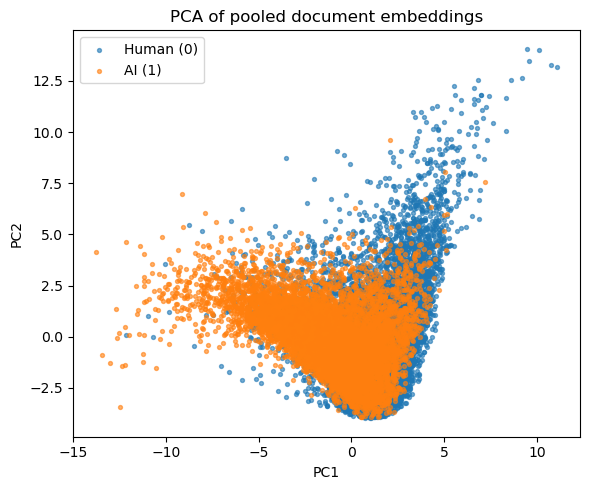

In [36]:
# 2. EDA / Exploration

def temporal_pool(features: np.ndarray, mode: str = "meanmaxstd") -> np.ndarray:
    """
    Pool along time dimension (T) to derive document-level features.
    Options:
      - "mean": mean over T
      - "meanmax": [mean, max]
      - "meanmaxstd": [mean, max, std]
    """
    if mode == "mean":
        return features.mean(axis=1)
    elif mode == "meanmax":
        mean = features.mean(axis=1)
        mx = features.max(axis=1)
        return np.concatenate([mean, mx], axis=1)
    elif mode == "meanmaxstd":
        mean = features.mean(axis=1)
        mx = features.max(axis=1)
        std = features.std(axis=1)
        return np.concatenate([mean, mx, std], axis=1)
    else:
        raise ValueError("Unknown pooling mode")

# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution (train):", dict(zip(unique, counts)))

# PCA visualisation on pooled doc embeddings
pooled_train = temporal_pool(X_train, mode="meanmaxstd")
pca = PCA(n_components=2, random_state=SEED)
train_2d = pca.fit_transform(pooled_train)

plt.figure(figsize=(6,5))
plt.scatter(train_2d[y_train==0,0], train_2d[y_train==0,1], s=8, label="Human (0)", alpha=0.6)
plt.scatter(train_2d[y_train==1,0], train_2d[y_train==1,1], s=8, label="AI (1)", alpha=0.6)
plt.title("PCA of pooled document embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout()
plt.show()


In [37]:
# 3. Baselines (Benchmark Low)
def train_eval_baseline(
    X: np.ndarray, y: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    mode: str = "meanmaxstd",
    model_type: str = "logreg",
    cv_folds: int = 5
):
    # Pool to fixed-size vectors
    X_doc = temporal_pool(X, mode=mode)
    X_val_doc = temporal_pool(X_val, mode=mode)

    # Standardise features (fit on train only)
    scaler = StandardScaler()
    X_doc_std = scaler.fit_transform(X_doc)
    X_val_std = scaler.transform(X_val_doc)

    # Cross-validation score for sanity
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=SEED)
    cv_acc, cv_f1 = [], []

    for tr_idx, te_idx in skf.split(X_doc_std, y):
        X_tr, X_te = X_doc_std[tr_idx], X_doc_std[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        if model_type == "logreg":
            model = LogisticRegression(max_iter=3000, n_jobs=-1, class_weight="balanced", random_state=SEED)
        elif model_type == "rf":
            model = RandomForestClassifier(
                n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                n_jobs=-1, class_weight="balanced", random_state=SEED
            )
        else:
            raise ValueError("Unknown model_type")

        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        cv_acc.append(accuracy_score(y_te, preds))
        cv_f1.append(f1_score(y_te, preds))

    print(f"[{model_type.upper()}] CV Acc: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f} | CV F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

    # Fit on full train and evaluate on provided validation
    if model_type == "logreg":
        final_model = LogisticRegression(max_iter=3000, n_jobs=-1, class_weight="balanced", random_state=SEED)
    else:
        final_model = RandomForestClassifier(
            n_estimators=600, n_jobs=-1, class_weight="balanced", random_state=SEED
        )

    final_model.fit(X_doc_std, y)
    val_preds = final_model.predict(X_val_std)
    val_probs = (final_model.predict_proba(X_val_std)[:,1]
                 if hasattr(final_model, "predict_proba") else val_preds.astype(float))

    print("\nValidation classification report:")
    print(classification_report(y_val, val_preds, digits=4))
    try:
        print("Validation ROC-AUC:", roc_auc_score(y_val, val_probs))
    except Exception:
        pass

    # Save artifacts
    tag = f"{model_type}_{mode}"
    joblib.dump(scaler, os.path.join(cfg.artifacts_dir, f"scaler_{tag}.joblib"))
    joblib.dump(final_model, os.path.join(cfg.artifacts_dir, f"baseline_{tag}.joblib"))
    return final_model, scaler, val_preds, val_probs

# ---- Run baselines on validation ----
logreg_model, logreg_scaler, lr_val_preds, lr_val_probs = train_eval_baseline(
    X_train, y_train, X_valid, y_valid, mode="meanmaxstd", model_type="logreg"
)

rf_model, rf_scaler, rf_val_preds, rf_val_probs = train_eval_baseline(
    X_train, y_train, X_valid, y_valid, mode="meanmaxstd", model_type="rf"
)


[LOGREG] CV Acc: 0.8852 ± 0.0061 | CV F1: 0.8856 ± 0.0068

Validation classification report:
              precision    recall  f1-score   support

           0     0.5333    0.8000    0.6400        10
           1     0.6000    0.3000    0.4000        10

    accuracy                         0.5500        20
   macro avg     0.5667    0.5500    0.5200        20
weighted avg     0.5667    0.5500    0.5200        20

Validation ROC-AUC: 0.62
[RF] CV Acc: 0.8425 ± 0.0051 | CV F1: 0.8421 ± 0.0054

Validation classification report:
              precision    recall  f1-score   support

           0     0.5833    0.7000    0.6364        10
           1     0.6250    0.5000    0.5556        10

    accuracy                         0.6000        20
   macro avg     0.6042    0.6000    0.5960        20
weighted avg     0.6042    0.6000    0.5960        20

Validation ROC-AUC: 0.585


In [40]:
# =========================================================
# 4. Deep Learning Datasets & Dataloaders
# - We keep sequence length T and dim D
# =========================================================
class EmbeddingSequenceDataset(Dataset):
    def __init__(self, X: np.ndarray, y: Optional[np.ndarray] = None):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64) if y is not None else None

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = self.X[idx]  # (T, D)
        if self.y is None:
            return torch.from_numpy(sample)
        return torch.from_numpy(sample), torch.tensor(self.y[idx], dtype=torch.long)

def make_loaders(X_tr, y_tr, X_v, y_v, batch_size=32, num_workers=0):
    ds_tr = EmbeddingSequenceDataset(X_tr, y_tr)
    ds_v = EmbeddingSequenceDataset(X_v, y_v)
    tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    va = DataLoader(ds_v, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return tr, va

train_loader, valid_loader = make_loaders(X_train, y_train, X_valid, y_valid, cfg.batch_size, cfg.num_workers)


In [41]:
# 5. Deep Models
class SelfAttentionPooling(nn.Module):
    """Learnable attention over time dimension."""
    def __init__(self, dim, hidden=128):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):  # x: (B, T, H)
        scores = self.attn(x).squeeze(-1)           # (B, T)
        weights = torch.softmax(scores, dim=1)      # (B, T)
        pooled = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (B, H)
        return pooled, weights

class BiGRUAttn(nn.Module):
    def __init__(self, input_dim, hidden=256, layers=1, dropout=0.3):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden, num_layers=layers,
                          batch_first=True, bidirectional=True, dropout=0.0 if layers==1 else dropout)
        self.pool = SelfAttentionPooling(hidden*2, hidden=hidden)
        self.out = nn.Sequential(
            nn.Linear(hidden*2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):  # x: (B, T, D)
        out, _ = self.rnn(x)            # (B, T, 2H)
        pooled, _ = self.pool(out)      # (B, 2H)
        logits = self.out(pooled)       # (B, 1)
        return logits.squeeze(-1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):  # (B, T, D)
        T = x.size(1)
        return x + self.pe[:, :T, :]

class LightTransformer(nn.Module):
    def __init__(self, input_dim, n_heads=8, hidden=512, layers=2, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden)
        self.pos = PositionalEncoding(hidden, max_len=2048)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden, nhead=n_heads, dim_feedforward=hidden*2, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.pool = SelfAttentionPooling(hidden, hidden=hidden//2)
        self.out = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)
        )

    def forward(self, x):  # x: (B, T, D)
        h = self.input_proj(x)
        h = self.pos(h)
        h = self.encoder(h)
        pooled, _ = self.pool(h)
        logits = self.out(pooled)
        return logits.squeeze(-1)


In [42]:
# 6. Training / Evaluation Loops (Deep)
def metrics_from_logits(logits: torch.Tensor, y_true: torch.Tensor, threshold: float = 0.5):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = (probs >= threshold).astype(int)
    y_true_np = y_true.detach().cpu().numpy()
    return (accuracy_score(y_true_np, preds),
            f1_score(y_true_np, preds),
            roc_auc_score(y_true_np, probs) if len(np.unique(y_true_np))>1 else np.nan,
            probs, preds)

def train_one_epoch(model, loader, optimizer, criterion, device, clip=1.0):
    model.train()
    total_loss = 0.0
    for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.float().to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        if clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_logits, all_labels = [], []
    for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device).float()
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        all_logits.append(logits.detach().cpu())
        all_labels.append(y.detach().cpu())
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels).long()
    acc, f1, auc, probs, preds = metrics_from_logits(all_logits, all_labels, threshold)
    return total_loss/len(loader.dataset), acc, f1, auc, probs, preds

def train_deep_model(model, train_loader, valid_loader, cfg: CFG, tag: str):
    model = model.to(cfg.device)
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    best_f1, best_state, patience = -1.0, None, cfg.early_stopping_patience
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": [], "val_auc": []}

    for epoch in range(1, cfg.epochs+1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, cfg.device, cfg.grad_clip)
        va_loss, acc, f1, auc, _, _ = evaluate(model, valid_loader, criterion, cfg.device, cfg.threshold)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(acc)
        history["val_f1"].append(f1)
        history["val_auc"].append(auc)

        print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
              f"val_acc={acc:.4f} | val_f1={f1:.4f} | val_auc={auc:.4f}")

        # Early stopping on F1
        if f1 > best_f1:
            best_f1 = f1
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}
            torch.save(best_state, os.path.join(cfg.artifacts_dir, f"{tag}_best.pt"))
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}. Best F1={best_f1:.4f}")
                break

    # Load best
    if best_state is not None:
        model.load_state_dict({k: v.to(cfg.device) for k, v in best_state.items()})
    # Save final model
    torch.save(model.state_dict(), os.path.join(cfg.artifacts_dir, f"{tag}_final.pt"))
    return model, history


In [43]:
# 7. Train Deep Models
bigru = BiGRUAttn(input_dim=cfg.D, hidden=cfg.rnn_hidden, layers=cfg.rnn_layers, dropout=cfg.rnn_dropout)
bigru, hist_gru = train_deep_model(bigru, train_loader, valid_loader, cfg, tag="bigru_attn")

# 7.2 Light Transformer
light_tf = LightTransformer(input_dim=cfg.D, n_heads=cfg.tf_n_heads, hidden=cfg.tf_hidden,
                            layers=cfg.tf_layers, dropout=cfg.tf_dropout)
light_tf, hist_tf = train_deep_model(light_tf, train_loader, valid_loader, cfg, tag="light_transformer")


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train_loss=0.3718 | val_loss=0.7518 | val_acc=0.7500 | val_f1=0.6667 | val_auc=0.8800


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02 | train_loss=0.2944 | val_loss=1.0145 | val_acc=0.6500 | val_f1=0.6667 | val_auc=0.7500


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03 | train_loss=0.2629 | val_loss=0.6425 | val_acc=0.8000 | val_f1=0.7778 | val_auc=0.8300


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04 | train_loss=0.2478 | val_loss=0.6083 | val_acc=0.7000 | val_f1=0.7000 | val_auc=0.7900


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05 | train_loss=0.2347 | val_loss=0.7023 | val_acc=0.7500 | val_f1=0.7059 | val_auc=0.7900


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06 | train_loss=0.2285 | val_loss=0.9340 | val_acc=0.7500 | val_f1=0.7059 | val_auc=0.7300


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07 | train_loss=0.2165 | val_loss=0.6973 | val_acc=0.6500 | val_f1=0.5882 | val_auc=0.7600
Early stopping at epoch 7. Best F1=0.7778


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train_loss=0.5738 | val_loss=1.0510 | val_acc=0.5000 | val_f1=0.5000 | val_auc=0.4900


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02 | train_loss=0.5167 | val_loss=1.0680 | val_acc=0.5500 | val_f1=0.4706 | val_auc=0.5500


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03 | train_loss=0.5253 | val_loss=0.8471 | val_acc=0.5500 | val_f1=0.1818 | val_auc=0.5400


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04 | train_loss=0.5440 | val_loss=1.1617 | val_acc=0.3500 | val_f1=0.5185 | val_auc=0.5200


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05 | train_loss=0.5195 | val_loss=1.9562 | val_acc=0.4000 | val_f1=0.5714 | val_auc=0.4800


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06 | train_loss=0.5202 | val_loss=1.2804 | val_acc=0.4000 | val_f1=0.5714 | val_auc=0.3200


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07 | train_loss=0.5128 | val_loss=1.7568 | val_acc=0.3500 | val_f1=0.4800 | val_auc=0.4000


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08 | train_loss=0.5052 | val_loss=0.7473 | val_acc=0.5000 | val_f1=0.0000 | val_auc=0.6300


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09 | train_loss=0.4753 | val_loss=1.0844 | val_acc=0.5000 | val_f1=0.4444 | val_auc=0.5300
Early stopping at epoch 9. Best F1=0.5714


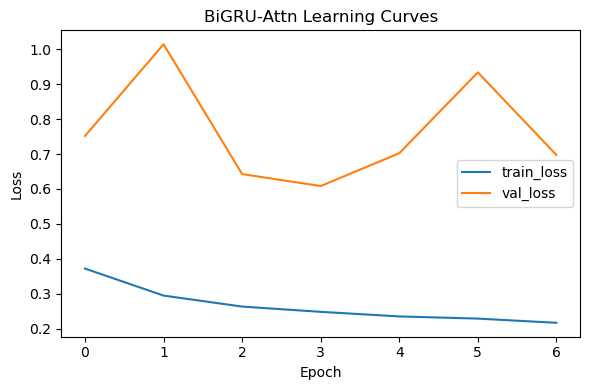

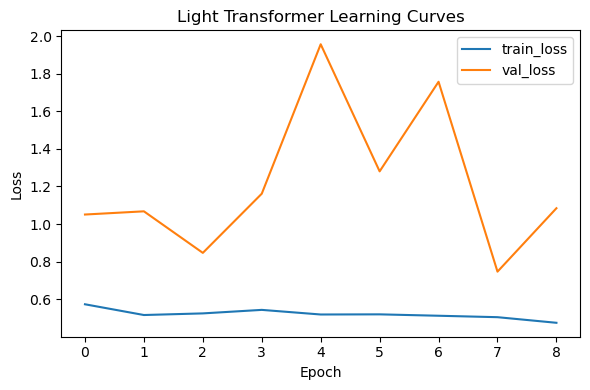

BiGRU-Attn:  Acc=0.6500 F1=0.5882 AUC=0.7600
Transformer: Acc=0.5000 F1=0.4444 AUC=0.5300

BiGRU classification report:
              precision    recall  f1-score   support

           0     0.6154    0.8000    0.6957        10
           1     0.7143    0.5000    0.5882        10

    accuracy                         0.6500        20
   macro avg     0.6648    0.6500    0.6419        20
weighted avg     0.6648    0.6500    0.6419        20

Confusion Matrix (BiGRU):
[[8 2]
 [5 5]]

Transformer classification report:
              precision    recall  f1-score   support

           0     0.5000    0.6000    0.5455        10
           1     0.5000    0.4000    0.4444        10

    accuracy                         0.5000        20
   macro avg     0.5000    0.5000    0.4949        20
weighted avg     0.5000    0.5000    0.4949        20

Confusion Matrix (Transformer):
[[6 4]
 [6 4]]


C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\rybha\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [44]:
# 8
def plot_history(hist, title="Learning Curves"):
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
    plt.show()

plot_history(hist_gru, "BiGRU-Attn Learning Curves")
plot_history(hist_tf, "Light Transformer Learning Curves")

# Detailed metrics (validation set)
criterion = nn.BCEWithLogitsLoss()
bigru.to(cfg.device)
tf_model = light_tf.to(cfg.device)

_, acc_g, f1_g, auc_g, p_g, yhat_g = evaluate(bigru, valid_loader, criterion, cfg.device, cfg.threshold)
_, acc_t, f1_t, auc_t, p_t, yhat_t = evaluate(tf_model, valid_loader, criterion, cfg.device, cfg.threshold)

print("BiGRU-Attn:  Acc={:.4f} F1={:.4f} AUC={:.4f}".format(acc_g, f1_g, auc_g))
print("Transformer: Acc={:.4f} F1={:.4f} AUC={:.4f}".format(acc_t, f1_t, auc_t))

print("\nBiGRU classification report:")
print(classification_report(y_valid, yhat_g, digits=4))
print("Confusion Matrix (BiGRU):")
print(confusion_matrix(y_valid, yhat_g))

print("\nTransformer classification report:")
print(classification_report(y_valid, yhat_t, digits=4))
print("Confusion Matrix (Transformer):")
print(confusion_matrix(y_valid, yhat_t))


In [45]:
# 9
probs_stack = []
names = []

if lr_val_probs is not None:
    probs_stack.append(lr_val_probs)
    names.append("LogReg")
if rf_val_probs is not None:
    probs_stack.append(rf_val_probs)
    names.append("RandomForest")
if p_g is not None:
    probs_stack.append(p_g)
    names.append("BiGRU")
if p_t is not None:
    probs_stack.append(p_t)
    names.append("Transformer")

probs_stack = np.vstack(probs_stack)  # (K, N_val)
ens_probs = probs_stack.mean(axis=0)  # average
ens_preds = (ens_probs >= cfg.threshold).astype(int)

print("Ensemble of:", names)
print("Val Acc:", accuracy_score(y_valid, ens_preds))
print("Val F1 :", f1_score(y_valid, ens_preds))
try:
    print("Val AUC:", roc_auc_score(y_valid, ens_probs))
except Exception:
    pass

print("\nEnsemble classification report:")
print(classification_report(y_valid, ens_preds, digits=4))


Ensemble of: ['LogReg', 'RandomForest', 'BiGRU', 'Transformer']
Val Acc: 0.6
Val F1 : 0.5555555555555556
Val AUC: 0.66

Ensemble classification report:
              precision    recall  f1-score   support

           0     0.5833    0.7000    0.6364        10
           1     0.6250    0.5000    0.5556        10

    accuracy                         0.6000        20
   macro avg     0.6042    0.6000    0.5960        20
weighted avg     0.6042    0.6000    0.5960        20



In [46]:


def pooled_inference_baseline(model, scaler, X: np.ndarray, mode: str = "meanmaxstd") -> np.ndarray:
    X_doc = temporal_pool(X, mode=mode)
    X_doc_std = scaler.transform(X_doc)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_doc_std)[:,1]
    # For models without proba, fallback to decision_function or predict
    if hasattr(model, "decision_function"):
        logits = model.decision_function(X_doc_std)
        probs = 1 / (1 + np.exp(-logits))
        return probs
    preds = model.predict(X_doc_std)
    return preds.astype(float)

@torch.no_grad()
def deep_inference(model, X: np.ndarray, batch_size=64, device="cpu") -> np.ndarray:
    ds = EmbeddingSequenceDataset(X, None)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model.eval()
    model.to(device)
    probs = []
    for batch in dl:
        x = batch.to(device)
        logits = model(x)
        p = torch.sigmoid(logits).cpu().numpy()
        probs.append(p)
    return np.concatenate(probs, axis=0)

def save_submission(ids: List[str], probs: np.ndarray, threshold: float, path: str):
    labels = (probs >= threshold).astype(int)
    sub = pd.DataFrame({"id": ids, "label": labels})
    sub.to_csv(path, index=False)
    print("Saved submission:", path)
    return sub

# ---- Load best deep weights (if early stopping saved better) ----
bigru_path = os.path.join(cfg.artifacts_dir, "bigru_attn_best.pt")
tf_path    = os.path.join(cfg.artifacts_dir, "light_transformer_best.pt")
if os.path.exists(bigru_path):
    bigru.load_state_dict(torch.load(bigru_path, map_location=cfg.device))
if os.path.exists(tf_path):
    light_tf.load_state_dict(torch.load(tf_path, map_location=cfg.device))

# ---- Generate test probabilities for each model you want in the ensemble ----
test_probs = []

# 1) Logistic Regression baseline
lr_tag = "logreg_meanmaxstd"
lr_model = joblib.load(os.path.join(cfg.artifacts_dir, f"baseline_{lr_tag}.joblib"))
lr_scaler = joblib.load(os.path.join(cfg.artifacts_dir, f"scaler_{lr_tag}.joblib"))
p_lr = pooled_inference_baseline(lr_model, lr_scaler, X_test, mode="meanmaxstd")
test_probs.append(p_lr)

# 2) Random Forest baseline
rf_tag = "rf_meanmaxstd"
rf_model = joblib.load(os.path.join(cfg.artifacts_dir, f"baseline_{rf_tag}.joblib"))
rf_scaler = joblib.load(os.path.join(cfg.artifacts_dir, f"scaler_{rf_tag}.joblib"))
p_rf = pooled_inference_baseline(rf_model, rf_scaler, X_test, mode="meanmaxstd")
test_probs.append(p_rf)

# 3) BiGRU-Attn
p_bigru = deep_inference(bigru, X_test, batch_size=64, device=cfg.device)
test_probs.append(p_bigru)

# 4) Light Transformer
p_tf = deep_inference(light_tf, X_test, batch_size=64, device=cfg.device)
test_probs.append(p_tf)

# ---- Average ensemble ----
test_probs = np.vstack(test_probs)  # (K, N_test)
test_probs_mean = test_probs.mean(axis=0)

# Save main submission (specify this in your report as the one to use)
sub_main_path = os.path.join(cfg.artifacts_dir, "submission_ensemble_mean.csv")
submission_df = save_submission(test_ids, test_probs_mean, cfg.threshold, sub_main_path)
submission_df.head()

Saved submission: artifacts\submission_ensemble_mean.csv


,id,label
0,15,0
1,16,1
2,17,0
3,18,1
4,19,1


In [47]:

# Individual submissions:
save_submission(test_ids, p_lr, cfg.threshold, os.path.join(cfg.artifacts_dir, "submission_logreg.csv"))
save_submission(test_ids, p_rf, cfg.threshold, os.path.join(cfg.artifacts_dir, "submission_rf.csv"))
save_submission(test_ids, p_bigru, cfg.threshold, os.path.join(cfg.artifacts_dir, "submission_bigru.csv"))
save_submission(test_ids, p_tf, cfg.threshold, os.path.join(cfg.artifacts_dir, "submission_transformer.csv"))

# Weighted ensemble (tune weights after checking validation performance)
w_lr, w_rf, w_gru, w_tf = 0.15, 0.15, 0.35, 0.35
weighted_probs = (w_lr*p_lr + w_rf*p_rf + w_gru*p_bigru + w_tf*p_tf) / (w_lr+w_rf+w_gru+w_tf)
save_submission(test_ids, weighted_probs, cfg.threshold, os.path.join(cfg.artifacts_dir, "submission_weighted.csv"))


Saved submission: artifacts\submission_logreg.csv
Saved submission: artifacts\submission_rf.csv
Saved submission: artifacts\submission_bigru.csv
Saved submission: artifacts\submission_transformer.csv
Saved submission: artifacts\submission_weighted.csv


,id,label
0,15,0
1,16,1
2,17,0
3,18,1
4,19,1
...,...,...
175,195,0
176,196,1
177,197,0
178,198,1


In [59]:

def load_and_predict_for_test(artifacts_dir: str, method: str = "ensemble_mean") -> pd.DataFrame:
    """
    method options:
      - 'logreg'
      - 'rf'
      - 'bigru'
      - 'transformer'
      - 'ensemble_mean'
    """
    # Re-load test (safety if grader runs this cell only)
    X_t, ids_t = load_test(cfg.test_jsonl, cfg.T, cfg.D)

    if method == "logreg":
        model = joblib.load(os.path.join(artifacts_dir, "baseline_logreg_meanmaxstd.joblib"))
        scaler = joblib.load(os.path.join(artifacts_dir, "scaler_logreg_meanmaxstd.joblib"))
        probs = pooled_inference_baseline(model, scaler, X_t, "meanmaxstd")
    elif method == "rf":
        model = joblib.load(os.path.join(artifacts_dir, "baseline_rf_meanmaxstd.joblib"))
        scaler = joblib.load(os.path.join(artifacts_dir, "scaler_rf_meanmaxstd.joblib"))
        probs = pooled_inference_baseline(model, scaler, X_t, "meanmaxstd")
    elif method == "bigru":
        m = BiGRUAttn(cfg.D, cfg.rnn_hidden, cfg.rnn_layers, cfg.rnn_dropout)
        m.load_state_dict(torch.load(os.path.join(artifacts_dir, "bigru_attn_best.pt"), map_location=cfg.device))
        probs = deep_inference(m, X_t, batch_size=64, device=cfg.device)
    elif method == "transformer":
        m = LightTransformer(cfg.D, cfg.tf_n_heads, cfg.tf_hidden, cfg.tf_layers, cfg.tf_dropout)
        m.load_state_dict(torch.load(os.path.join(artifacts_dir, "light_transformer_best.pt"), map_location=cfg.device))
        probs = deep_inference(m, X_t, batch_size=64, device=cfg.device)
    elif method == "ensemble_mean":
        # Compose from saved components
        lr_m = joblib.load(os.path.join(artifacts_dir, "baseline_logreg_meanmaxstd.joblib"))
        lr_s = joblib.load(os.path.join(artifacts_dir, "scaler_logreg_meanmaxstd.joblib"))
        rf_m = joblib.load(os.path.join(artifacts_dir, "baseline_rf_meanmaxstd.joblib"))
        rf_s = joblib.load(os.path.join(artifacts_dir, "scaler_rf_meanmaxstd.joblib"))

        p1 = pooled_inference_baseline(lr_m, lr_s, X_t, "meanmaxstd")
        p2 = pooled_inference_baseline(rf_m, rf_s, X_t, "meanmaxstd")

        m1 = BiGRUAttn(cfg.D, cfg.rnn_hidden, cfg.rnn_layers, cfg.rnn_dropout)
        m1.load_state_dict(torch.load(os.path.join(artifacts_dir, "bigru_attn_best.pt"), map_location=cfg.device))
        p3 = deep_inference(m1, X_t, batch_size=64, device=cfg.device)

        m2 = LightTransformer(cfg.D, cfg.tf_n_heads, cfg.tf_hidden, cfg.tf_layers, cfg.tf_dropout)
        m2.load_state_dict(torch.load(os.path.join(artifacts_dir, "light_transformer_best.pt"), map_location=cfg.device))
        p4 = deep_inference(m2, X_t, batch_size=64, device=cfg.device)

        probs = np.vstack([p1, p2, p3, p4]).mean(axis=0)
    else:
        raise ValueError("Unknown method")

    out_path = os.path.join(artifacts_dir, f"submission_{method}.csv")
    return save_submission(ids_t, probs, cfg.threshold, out_path)